In [1]:
# Import libs
import pandas as pd
import matplotlib.pyplot as plt
import gempy as gp
from gempy.utils import section_utils

WARNING (theano.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


# Init

In [2]:
# instantiate the geo_model
geo_model = gp.create_model("BaseModel")

# defautl data
geo_model = gp.init_data(
    geo_model,
    extent=[0, 1000, 0, 1000, 0, 1000],
    resolution=[10, 10, 10]
)

gp.set_interpolation_data(
    geo_model,
    compile_theano=True,
    theano_optimizer='fast_run',
)

Active grids: ['regular']
Setting kriging parameters to their default values.
Compiling theano function...
Level of Optimization:  fast_run
Device:  cpu
Precision:  float64
Number of faults:  0
Compilation Done!
Kriging values: 
                   values
range            1732.05
$C_o$            71428.6
drift equations      [3]


# Data

In [3]:
gpmodel_extent = {
    "x_min": 0,
    "x_max": 2000,
    "y_min": 0,
    "y_max": 2000,
    "z_min": 0,
    "z_max": 2000,
}

gpmodel_resolution = {
    "nx": 10,
    "ny": 10,
    "nz": 10
}

series_data = {
    'name': ['Fault_Series', 'Strat_Series'],
    'isfault': [True, False]
}
series_df = pd.DataFrame.from_dict(series_data)

surfaces_data = {
    'name': ['Main_Fault', 'Sandstone_2', 'Siltstone', 'Shale', 'Sandstone_1', 'basement'],
    'serie': ['Fault_Series', 'Strat_Series', 'Strat_Series', 'Strat_Series', 'Strat_Series', 'Strat_Series']
}
surfaces_df = pd.DataFrame.from_dict(surfaces_data)

input_data_surface_points_df = pd.read_csv('./data/simple_fault_model_points.csv')
input_data_surface_points_df = input_data_surface_points_df[['X', 'Y', 'Z', 'formation']]
input_data_surface_points_df.columns=['X', 'Y', 'Z', 'surface']

orientations_df = pd.read_csv('./data/simple_fault_model_orientations.csv')

canvas_resolution = {
    'widht': 2560,
    'height': 1920
}

section_dict = {
    'section': (
        [0, 1000],
        [2000, 1000],
        [
            int(canvas_resolution['widht'] / 10),  # set to lower computational time
            int(canvas_resolution['height'] / 10),  # set to lower computational time
        ],
    )
}

# Inner-Functions

In [4]:
def update_series(geo_model, series_df):
    
    series_old = list(geo_model.series.df.to_dict()['order_series'].keys())

    # add new series
    for index, row in series_df.iterrows():

        serie_name = row['name']
        serie_isfault = row['isfault']
        if serie_name not in series_old:

            geo_model.add_series(series_list=[serie_name])

    # remove obsolete series    
    for serie in series_old:

        if serie not in series_df['name'].to_list():

            geo_model.delete_series(serie)

In [5]:
def update_faults_relations(geo_model, series_df):

    for index, row in series_df.iterrows():
        
        serie_name = row['name']
        serie_isfault = row['isfault']        
        if serie_isfault:

            geo_model.set_is_fault([serie_name])

In [6]:
def update_surfaces(geo_model, surfaces_df):
    
    surfaces_old = geo_model.surfaces.df['surface'].to_list()

    # add and update surfaces
    for index, row in surfaces_df.iterrows():

        surface_name = row['name']
        surface_serie = row['serie']
        if surface_name not in surfaces_old:

            geo_model.add_surfaces(surface_list=[surface_name])
            gp.map_series_to_surfaces(
                geo_model,
                {surface_serie:surface_name}
            )

        else:

            gp.map_series_to_surfaces(
                geo_model,
                {surface_serie:surface_name}
            )


    # remove obsolete surfaces
    for surface in surfaces_old:

        if surface not in surfaces_df['name'].to_list():

            geo_model.delete_surfaces(surface)

# Main Function

In [7]:
def calulate_solution():    
    
    # Add topoligical data
    update_series(geo_model=geo_model, series_df=series_df)
    update_surfaces(geo_model=geo_model, surfaces_df=surfaces_df)
    
    # Set initial geo_model data including geological input_data
    gp.init_data(
        geo_model,
        extent=geo_model_extent,
        resolution=[10, 10, 10],
        surface_points_df=input_data_surface_points_df,
        orientations_df=orientations_df,
        update_surfaces=False
    )
    
    # Update fault realtions
    update_faults_relations(geo_model, series_df)
    
    # Update model to interpolator
    geo_model.update_to_interpolator()

    # Set section grid  # Only one => client canvas
    geo_model.set_section_grid(section_dict=section_dict)

    # Compute model 2x  # Due to buggy behaviour
    # TODO: Reapalce or fix
    solution = gp.compute_model(
        model=geo_model,
        compute_mesh=False  # Avoide unecessay computation
    )
    solution = gp.compute_model(
        model=geo_model,
        compute_mesh=False  # Avoide unecessay computation
    )

# Postprocessing

In [8]:
def process_client_section_polygons(polygondict, extent, canvas_resolution):

    keys = list(polygondict.keys())
    polygons_dict = {}
    # loop over rock units
    for key in keys:

        # extract polygons of rock unit
        polygons = polygondict[key]

        # if polygons of rock unit present
        if polygons:

            # loop over plygons of rock unit i
            for index, polygon in enumerate(polygons):

                # rescale towards original canvas resolution
                polygon[:, 0] = (
                    # polygon[:, 0] / extent[1] * (canvas_resolution["widht"] - 250)
                    polygon[:, 0] / extent[1] * (canvas_resolution["widht"])
                )
                polygon[:, 1] = (
                    # polygon[:, 1] / extent[3] * (canvas_resolution["height"] - 90)
                    polygon[:, 1] / extent[3] * (canvas_resolution["height"])
                )

                # polygons_dict[f'{key}_{index}'] = polygon.flatten().tolist()
                polygons_dict[f'{key}_{index}'] = polygon
                
    # retrun polygons_dict
    return polygons_dict

# Pipeline

In [9]:
canvas_resolution = {
    'widht': 2560,
    'height': 1920
}

section_dict = {
    'section': (
        [0, 1000],
        [2000, 1000],
        [
            # TODO: Add api
            int(canvas_resolution['widht'] / 20),  # set to lower computational cost
            int(canvas_resolution['height'] / 20),  # set to lower computational cost
        ],
    )
}

geo_model_extent = [0,2000,0,2000,0,2000]

Active grids: ['regular']
Fault colors changed. If you do not like this behavior, set change_color to False.
Active grids: ['regular' 'sections']


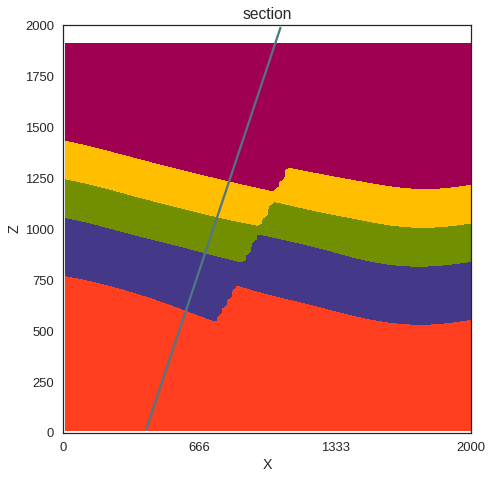

In [10]:
# %%timeit  # ~1s
calulate_solution()

polygondict, cdict, extent = gp.utils.section_utils.get_polygon_dictionary(
    geo_model=geo_model,
    section_name='section'
)

polygons_dict = process_client_section_polygons(
    polygondict=polygondict,
    extent=extent,
    canvas_resolution=canvas_resolution
)

In [11]:
keys = list(polygondict.keys())
polygons_dict = {}
# loop over rock units
for key in keys:

    # extract polygons of rock unit
    polygons = polygondict[key]

    # if polygons of rock unit present
    if polygons:

        # loop over plygons of rock unit i
        for index, polygon in enumerate(polygons):

            # rescale towards original canvas resolution
            polygon[:, 0] = (
                # polygon[:, 0] / extent[1] * (canvas_resolution["widht"] - 250)
                polygon[:, 0] / extent[1] * (canvas_resolution["widht"])
            )
            polygon[:, 1] = (
                # polygon[:, 1] / extent[3] * (canvas_resolution["height"] - 90)
                polygon[:, 1] / extent[3] * (canvas_resolution["height"])
            )

            # polygons_dict[f'{key}_{index}'] = polygon.flatten().tolist()
            polygons_dict[f'{key}_{index}'] = polygon

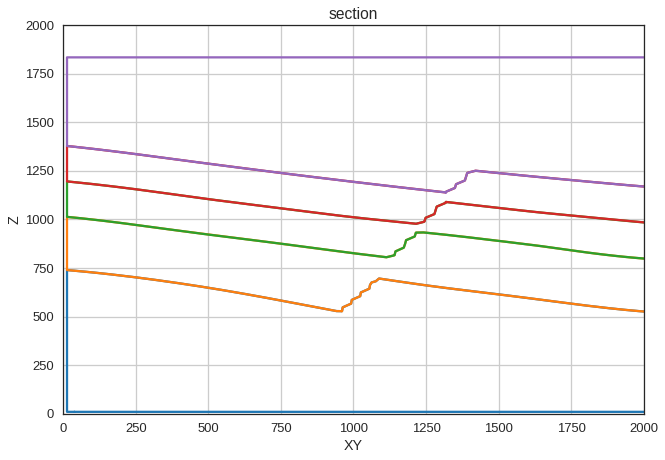

In [12]:
fig, ax = plt.subplots()

polygons_dict_keys = list(polygons_dict.keys())
for key in polygons_dict_keys:
    
    polygon = polygons_dict[key]
    ax.plot(polygon[:,0], polygon[:,1]) 
    
ax.set(xlabel='XY', ylabel='Z', title='section')
plt.grid()
plt.xlim(0, 2000)
plt.ylim(0, 2000)

plt.show()